In [51]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [6]:
from mmm import count_probs, get_list, get_stocks_type, count_logs, count_logs_fixed, get_last_n, get_stats, get_data


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
import jsonim

In [128]:
d = get_data('BABA')

df = pd.DataFrame(data=get_data('BABA')[1])

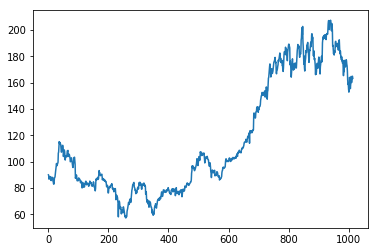

In [132]:
pyplot.plot(values[:,2])
pyplot.show()

In [133]:
# load dataset
data = df[['open', 'high', 'low', 'close', 'volume']].values
values = data
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
print(values)
scaled = scaler.fit_transform(values)
print('----')
print(scaled)
# specify the number of lag hours
n_hours = 10
n_features = 4
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

[[  92.7    99.7    89.95   93.89 1014.  ]
 [  92.7    92.95   89.5    89.89 1003.  ]
 [  88.94   90.48   86.62   87.17  975.  ]
 ...
 [ 165.52  167.39  164.87  165.4   449.  ]
 [ 166.39  167.05  164.92  166.32  387.  ]
 [ 164.9   165.66  163.3   164.76  233.  ]]
----
[[0.23190305 0.26821297 0.21788299 0.23783147 1.        ]
 [0.23190305 0.22410977 0.21488923 0.2117678  0.9891519 ]
 [0.20727155 0.20797127 0.19572884 0.19404441 0.9615385 ]
 ...
 [0.70894206 0.7104869  0.7163196  0.70378566 0.4428008 ]
 [0.71464133 0.7082653  0.7166522  0.70978045 0.3816568 ]
 [0.7048805  0.69918334 0.7058745  0.6996155  0.22978304]]
(1005, 55)


In [107]:
365 * 24

8760

In [134]:
# split into train and test sets
values = reframed.values
n_train_hours = 800
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(800, 40) 800 (800,)
(800, 10, 4) (800,) (205, 10, 4) (205,)


In [109]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network

history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history

Train on 800 samples, validate on 205 samples
Epoch 1/50
 - 2s - loss: 0.1489 - val_loss: 0.0956
Epoch 2/50
 - 0s - loss: 0.1502 - val_loss: 0.0704
Epoch 3/50
 - 0s - loss: 0.1201 - val_loss: 0.2952
Epoch 4/50
 - 0s - loss: 0.0674 - val_loss: 0.1199
Epoch 5/50
 - 0s - loss: 0.0620 - val_loss: 0.0536
Epoch 6/50
 - 0s - loss: 0.0637 - val_loss: 0.0538
Epoch 7/50
 - 0s - loss: 0.0486 - val_loss: 0.0593
Epoch 8/50
 - 0s - loss: 0.0703 - val_loss: 0.0820
Epoch 9/50
 - 0s - loss: 0.0450 - val_loss: 0.0724
Epoch 10/50
 - 0s - loss: 0.0707 - val_loss: 0.1146
Epoch 11/50
 - 0s - loss: 0.0384 - val_loss: 0.0588
Epoch 12/50
 - 0s - loss: 0.0580 - val_loss: 0.0626
Epoch 13/50
 - 0s - loss: 0.0407 - val_loss: 0.0570
Epoch 14/50
 - 0s - loss: 0.0580 - val_loss: 0.0681
Epoch 15/50
 - 0s - loss: 0.0391 - val_loss: 0.0583
Epoch 16/50
 - 0s - loss: 0.0569 - val_loss: 0.0723
Epoch 17/50
 - 0s - loss: 0.0367 - val_loss: 0.0556
Epoch 18/50
 - 0s - loss: 0.0513 - val_loss: 0.0560
Epoch 19/50
 - 0s - loss: 0

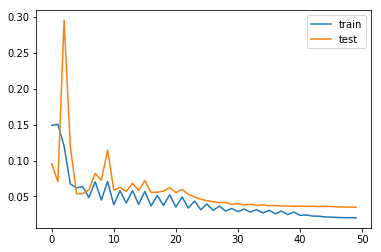

In [119]:
#print(history.history)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [118]:
test_X

array([[[0.8716018 , 0.86840904, 0.875524  , 0.86994195],
        [0.7248521 , 0.8793973 , 0.8696505 , 0.87931603],
        [0.8630351 , 0.4852071 , 0.8653128 , 0.86932385],
        ...,
        [0.798332  , 0.964497  , 0.8007207 , 0.7915715 ],
        [0.79249555, 0.77989185, 0.8668639 , 0.7728137 ],
        [0.7915715 , 0.7757302 , 0.7637975 , 0.87968445]],

       [[0.8793973 , 0.8696505 , 0.87931603, 0.8630351 ],
        [0.4852071 , 0.8653128 , 0.86932385, 0.87485856],
        [0.87183166, 0.19428009, 0.8725189 , 0.86769235],
        ...,
        [0.77989185, 0.8668639 , 0.7728137 , 0.7915715 ],
        [0.7757302 , 0.7637975 , 0.87968445, 0.785457  ],
        [0.77706635, 0.73887295, 0.73102236, 0.9497042 ]],

       [[0.8653128 , 0.86932385, 0.87485856, 0.87183166],
        [0.19428009, 0.8725189 , 0.86769235, 0.8672078 ],
        [0.85124123, 0.52169627, 0.8616444 , 0.85233593],
        ...,
        [0.7637975 , 0.87968445, 0.785457  , 0.77706635],
        [0.73887295, 0.731022

In [135]:
test_X

array([[[0.8716018 , 0.86840904, 0.875524  , 0.86994195],
        [0.7248521 , 0.8793973 , 0.8696505 , 0.87931603],
        [0.8630351 , 0.4852071 , 0.8653128 , 0.86932385],
        ...,
        [0.798332  , 0.964497  , 0.8007207 , 0.7915715 ],
        [0.79249555, 0.77989185, 0.8668639 , 0.7728137 ],
        [0.7915715 , 0.7757302 , 0.7637975 , 0.87968445]],

       [[0.8793973 , 0.8696505 , 0.87931603, 0.8630351 ],
        [0.4852071 , 0.8653128 , 0.86932385, 0.87485856],
        [0.87183166, 0.19428009, 0.8725189 , 0.86769235],
        ...,
        [0.77989185, 0.8668639 , 0.7728137 , 0.7915715 ],
        [0.7757302 , 0.7637975 , 0.87968445, 0.785457  ],
        [0.77706635, 0.73887295, 0.73102236, 0.9497042 ]],

       [[0.8653128 , 0.86932385, 0.87485856, 0.87183166],
        [0.19428009, 0.8725189 , 0.86769235, 0.8672078 ],
        [0.85124123, 0.52169627, 0.8616444 , 0.85233593],
        ...,
        [0.7637975 , 0.87968445, 0.785457  , 0.77706635],
        [0.73887295, 0.731022

In [136]:
# make a prediction
yhat = model.predict(test_X)
yhat_train = model.predict(train_X)
test_p_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
test_p_X_train = test_X.reshape((train_X.shape[0], n_hours*n_features))


# invert scaling for forecast
inv_yhat_test = concatenate((yhat_train, test_p_X_train[:, -4:]), axis=1)
print(inv_yhat_test.shape)
inv_yhat_test = scaler.inverse_transform(inv_yhat_test)
inv_yhat_test = inv_yhat_test[:,0]


# invert scaling for forecast
inv_yhat = concatenate((yhat, test_p_X[:, -4:]), axis=1)
print(inv_yhat.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_p_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: cannot reshape array of size 8200 into shape (800,40)

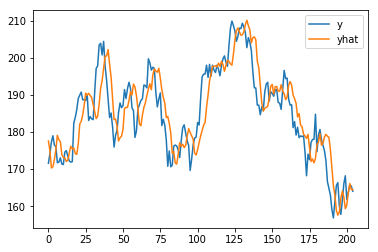

In [115]:
pyplot.plot(test_p_X_train, label='y')
pyplot.plot(inv_y, label='y')
pyplot.plot(inv_yhat, label='yhat')
pyplot.legend()
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict([test_X])